# PyREx Demo
### Python code for simulation of Askaryan radio detectors

PyREx = **Py**thon package for an IceCube **R**adio **Ex**tension

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrex

## Table of Contents

[Askaryan Signals](#askaryan_signals)

[Thermal Noise](#thermal_noise)

[Antennas](#antennae)

[Event Kernel](#event_kernel)

<a id='askaryan_signals'></a>
# Askaryan Signals

PyREx generates full-waveform Askaryan pulses based on the parametrization of [Alvarez-Muñiz, Romero-Wolf, & Zas](https://arxiv.org/pdf/1106.6283v3.pdf). It makes use of convolutions to produce the waveform quickly.

In [2]:
pyrex.AskaryanSignal?

In [3]:
time_array = np.linspace(0, 50e-9, 1001) # seconds
time_offset = 10e-9 # seconds
neutrino_energy = 1e8 # GeV
observation_angle = 45*np.pi/180 # radians
ask = pyrex.AskaryanSignal(times=time_array, energy=neutrino_energy,
                           theta=observation_angle, t0=time_offset)

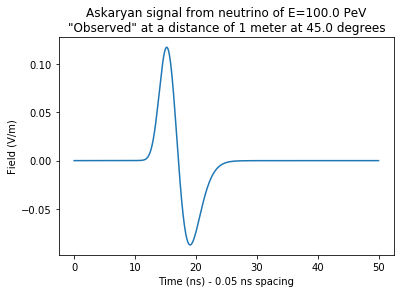

In [4]:
plt.plot(ask.times * 1e9, ask.values)
plt.title("Askaryan signal from neutrino of E="+str(neutrino_energy*1e-6)
          +" PeV\n\"Observed\" at a distance of 1 meter at "
          +str(observation_angle*180/np.pi)+" degrees")
plt.xlabel("Time (ns) - "+str(ask.dt*1e9)+" ns spacing")
plt.ylabel("Field (V/m)")
plt.show()

<a id='thermal_noise'></a>
# Thermal Noise

The thermal noise produced in PyREx is Rayleigh noise which has been passed through a bandpass filter. This is the same as the thermal noise model used in [ANITA](https://www.phys.hawaii.edu/elog/anita_notes/060228_110754/noise_simulation.ps).

The ThermalNoise class can be initialized with a given rms voltage or the rms voltage can be calculated by providing a temperature and resistance.

In [5]:
pyrex.ThermalNoise?

In [6]:
time_array = np.linspace(0, 50e-9, 1001) # s
temperature = 300 # K
resistance = 100 # ohm
frequency_band = (100e6, 400e6) # Hz
noise = pyrex.ThermalNoise(times=time_array, temperature=temperature,
                           resistance=resistance, f_band=frequency_band)

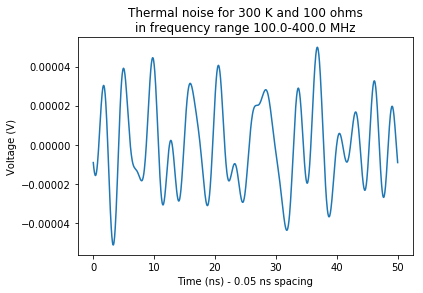

In [7]:
plt.plot(noise.times * 1e9, noise.values)
plt.title("Thermal noise for "+str(temperature)+" K and "
          +str(resistance)+" ohms\nin frequency range "
          +str(frequency_band[0]*1e-6)+"-"+str(frequency_band[1]*1e-6)+" MHz")
plt.xlabel("Time (ns) - "+str(noise.dt*1e9)+" ns spacing")
plt.ylabel("Voltage (V)")
plt.show()

PyREx also supports the addition of signal objects, as long as they have the same time array. For this example, let's scale the noise first so it's visible in addition to the signal.

In [8]:
noise.values *= 500
ask.value_type = pyrex.ValueTypes.voltage
total_signal = ask + noise

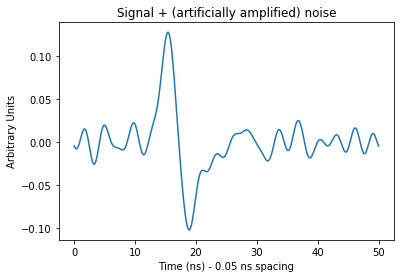

In [9]:
plt.plot(total_signal.times * 1e9, total_signal.values)
plt.title("Signal + (artificially amplified) noise")
plt.xlabel("Time (ns) - "+str(noise.dt*1e9)+" ns spacing")
plt.ylabel("Arbitrary Units")
plt.show()

<a id='antennas'></a>
# Antennas

PyREx provides an inheritable Antenna class to allow for customized antenna objects. It also contains a basic DipoleAntenna class as an example of the customization.

In [10]:
pyrex.Antenna?

In [11]:
position = (0,0,-250) # m
temperature = pyrex.IceModel.temperature(position[2]) # K
frequency_range = (550e6, 750e6) # Hz
ant = pyrex.Antenna(position=position, temperature=temperature,
                    freq_range=frequency_range, noisy=False)

is_hit property checks whether the antenna has been triggered

In [12]:
print("ant.is_hit =",ant.is_hit)

ant.is_hit = False


The base antenna class will trigger on any signal (EmptySignal is a convenience signal whose values are all zero) and has a flat frequency response

In [13]:
time_array = np.linspace(0, 50e-9)
incoming_singal = pyrex.EmptySignal(time_array)
print("trigger =",ant.trigger(incoming_singal))
frequencies = np.logspace(1,10)
print("response =",ant.response(frequencies))

trigger = True
response = [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


When the antenna receives a signal object, it processes it according to the antenna's frequency response and then adds it to the antenna.signals array. The full waveforms (including noise) of all triggered events are available as the antenna.waveforms array (all waveforms including those that don't trigger are available at antenna.all_waveforms). Noise signals are created on demand for the full waveforms, but are only one noise signal is calculated per event signal (so re-accessing antenna.waveforms will produce the same results each time).

len(ant.signals) before = 0
len(ant.signals) after = 1


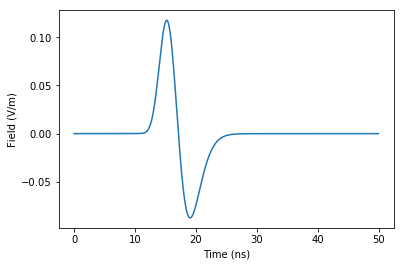

In [14]:
print("len(ant.signals) before =",len(ant.signals))
ant.receive(ask)
print("len(ant.signals) after =",len(ant.signals))
for w in ant.waveforms:
    plt.figure()
    plt.plot(w.times * 1e9, w.values)
    plt.xlabel("Time (ns)")
    plt.ylabel("Field (V/m)")
    plt.show()

The provided DipoleAntenna has a frequency response dictated by a first-order butterworth bandpass filter, and triggers based on whether the amplitude of the signal exceeds a threshold

In [15]:
pyrex.DipoleAntenna?

In [16]:
name = "antenna 1"
position = (0,0,-250) # m
center_frequency = 250e6 # Hz
bandwidth = 300e6 # Hz
resistance = 100 # ohm
effective_height = 3e8/center_frequency/2 # m
threshold = 75e-6 # V
dipole = pyrex.DipoleAntenna(name=name, position=position,
                             center_frequency=center_frequency,
                             bandwidth=bandwidth, resistance=resistance,
                             effective_height=effective_height,
                             trigger_threshold=threshold)

The dipole antenna will trigger if the signal amplitude multiplied by the antenna effective height (to convert to voltage) is greater than the antenna's threshold (after being passed through the antenna's bandpass filter). Note that the dipole._triggers array is a list of whether each signal that the antenna received was able to trigger the antenna (though it is not generated until antenna.waveforms is generated, so using it is generally not advisable).

triggered = True


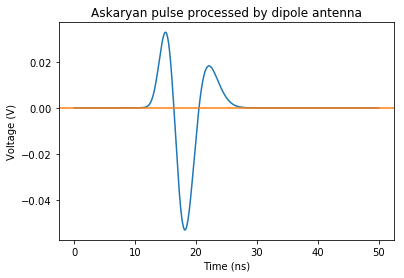

In [17]:
dipole.receive(ask)
wave = dipole.all_waveforms[-1]
plt.plot(wave.times * 1e9, wave.values)
plt.axhline(threshold, color="C1")
plt.title("Askaryan pulse processed by dipole antenna")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
dipole.is_hit
print("triggered =",dipole._triggers[-1])

triggered = False


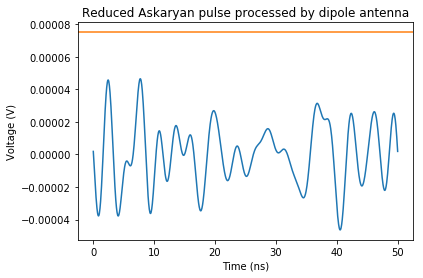

In [18]:
dipole.receive(pyrex.Signal(ask.times, ask.values/5000))
wave = dipole.all_waveforms[-1]
plt.plot(wave.times * 1e9, wave.values)
plt.axhline(threshold, color="C1")
plt.title("Reduced Askaryan pulse processed by dipole antenna")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
dipole.is_hit
print("triggered =",dipole._triggers[-1])

To clarify how antenna.signals, antenna.waveforms, and antenna.all_waveforms are related, print each array

In [19]:
print(dipole.signals)
print(dipole._triggers)
print(dipole.waveforms)
print(dipole.all_waveforms)
print("Is waveforms[0] the same as all_waveforms[0]?",
      np.array_equal(dipole.waveforms[0].values,dipole.all_waveforms[0].values))

[<pyrex.signals.Signal object at 0x10d68a898>, <pyrex.signals.Signal object at 0x10d713390>]
[True, False]
[<pyrex.signals.Signal object at 0x10d2c5ba8>, <pyrex.signals.Signal object at 0x10d2c5400>]
Is waveforms[0] the same as all_waveforms[0]? True


<a id='event_kernel'></a>
# Event Kernel

PyREx includes an EventKernel class that will produce particles based on a give particle generator and will handle sending their Askaryan pulses to a given array of antennas. The ShadowGenerator class will create particles with random direction in a spacial box, and will give them energies based on an energy generator function.

In [20]:
pyrex.Particle?

In [21]:
pyrex.ShadowGenerator?

In [22]:
pyrex.EventKernel?

In [28]:
width = 1000 # m
depth = 1000 # m
generator = pyrex.ShadowGenerator(dx=width, dy=width, dz=depth,
                                  energy_generator=lambda: 1e8) # energy in GeV

In [29]:
antennas = []
center_frequency = 250e6 # MHz
bandwidth = 300e6 # MHz
resistance = 100 # ohm
effective_height = 3e8/center_frequency/2 # m
threshold = 75e-6 # V
for i,z in enumerate([-100, -150, -200, -250]):
    antennas.append(
        pyrex.DipoleAntenna(name="antenna_"+str(i), position=(0,0,z),
                            center_frequency=center_frequency,
                            bandwidth=bandwidth, resistance=resistance,
                            effective_height=effective_height,
                            trigger_threshold=threshold)
    )

In [30]:
kernel = pyrex.EventKernel(generator=generator,
                           ice_model=pyrex.IceModel,
                           antennas=antennas)

The kernel generates particle events one at a time by calling kernel.event()

In [31]:
triggered = False
while not triggered:
    generated_particle = kernel.event()
    triggered = True in [ant.is_hit for ant in kernel.ant_array]
print("Generated",kernel.gen.count,"particles before triggering")
print(generated_particle)

Generated 19 particles before triggering
Particle(vertex=array([-484.89287769,   36.88599482, -500.66904686]), direction=[0.81030929344116798, -0.56082286269128889, -0.16993106145029202], energy=100000000.0)


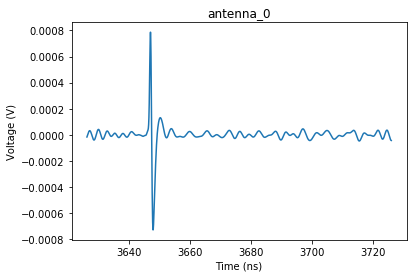

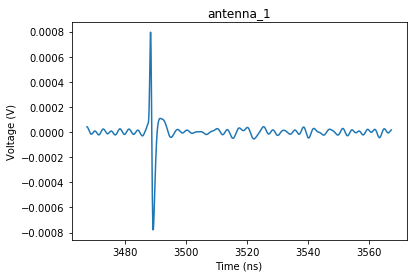

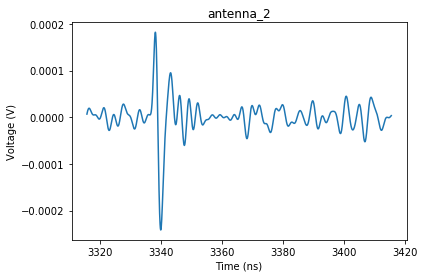

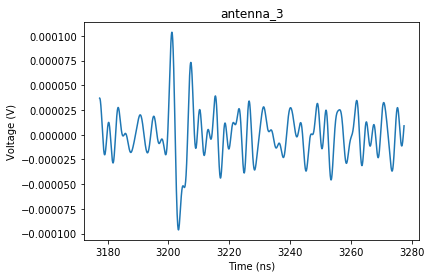

In [32]:
for ant in kernel.ant_array:
    for signal in ant.waveforms:
        plt.figure()
        plt.plot(signal.times * 1e9, signal.values)
        plt.title(ant.name)
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (V)")